# Toxic Comment Classification Challenge: Kaggle
[Link to the Kaggle competition page](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

This is a classic text classification problem, where one is given a corpus of text documents with labelled classes, and one has to perform supervised machine learning to first train the data, and then classify unseen documents. 


In [80]:
# Import the necessary libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display, HTML

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet

import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Load the train and test datasets and take a peek

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


 - No missing values! How many times do you get that? All the non-toxic text is already labelled as 0.

### Distribution of hate comments

In [6]:
count_labels_ser = train.select_dtypes(include=np.number).sum(axis=0)
#data.select_dtypes(include=np.number).isin([1]).any(axis=1).sum()
sum_toxic_comments = train.select_dtypes(include=np.number).apply(lambda row: any(row) == 1, axis=1).sum()
print('Total number of hate texts = {}, out of {}'.format(sum_toxic_comments, train.shape[0]))
print('Total number of clean comments: {}, out of {}'.format(train.shape[0] - sum_toxic_comments, train.shape[0]))

Total number of hate texts = 16225, out of 159571
Total number of clean comments: 143346, out of 159571


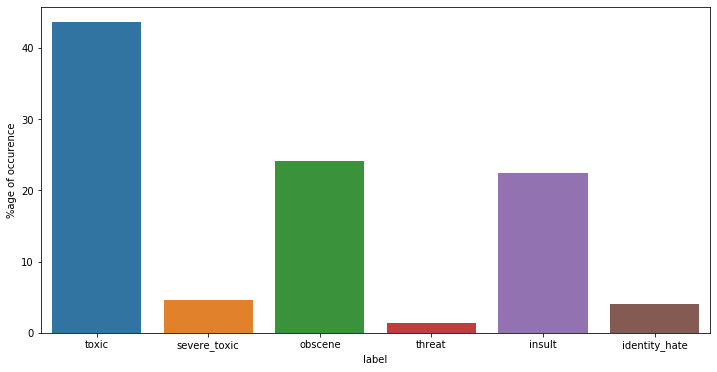

In [7]:
fig = plt.figure(figsize=(12,6))
_=sns.barplot(x=count_labels_ser.index,y=count_labels_ser/count_labels_ser.sum()*100)
_=plt.xlabel('label')
_=plt.ylabel('%age of occurence')

The data set is imbalanced, as you would expect. There are much fewer `severe_toxic` and `threat` comments than there are plain `toxic` ones.
Please note that that we have considered only those comments which have at least one of the toxicity flags set to 1. In other words, the clean (non-toxic) comments are not considered while calcualting the percentage.

- Next we will take a look at some random comments from each class of toxicity.

In [8]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for class_name in class_names:
    rand_text = np.random.choice(train[train[class_name]==1].index,size=1)[0] # Select a random comment from each class
    print('Example of {} text\n'.format(class_name), train.iloc[rand_text,1],'\n')

Example of toxic text
 are you a commie tho? 

Example of severe_toxic text
 What the fuck happened to my article bitches?! 

Example of obscene text
 Anna Frodesiak motherfucker bitch 

Example of threat text
 Die 

As that person said: ROT IN HELL YOU FUCKING LOSER!!! 

Example of insult text
 Hey, Halcy.Seems like you get mad alot. Want me to call the WAAAAAMBULANCE for you? Want some dick (extra small) with that too, bitch? U mad? butthurt? I bet you're having an orgy with MeetTheMedic and MeepTheSheep, aren't you? You three would make a good threesome. You're all reject 4-Chan trolls that became admins on another website to have Unwarranted Self Importance while you spam faggot and dick all day. Seems like you enjoy that kind of stuff. I had no idea, really.
 
TL;DR: U mad? 

Example of identity_hate text
 Fuck this bot 

Fuck you cluebot you suck quit reverting my shit man! Faggot! 70.234.221.234 



#### Lot of hate lurking there, beware!

- A particular comment can have multiple labels for 'toxicity'. For e.g. a comment can be both *toxic* and *obscene* at the same time.Taka a look at such a comment below.

In [9]:
train.iloc[6]

id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
Name: 6, dtype: object

How to find out the number of comments that are cross-labelled? A cross-tabulation of the counts (which is explored here) is one way, there might be better ways as well. 
- What you find is that there there is a huge overlap of severe_toxic, obscene, threat, etc. texts with toxic comments. This is also somewhat expected, obviously you expect a *severe toxic* comment to be *toxic* in the first place. 
- Similarly, only ~6% of all obscene comments are not labelled as toxic.

In [10]:
for col in train.columns[3:]:
    display(pd.crosstab(train['toxic'],train[col], margins=True))

severe_toxic,0,1,All
toxic,,,
0,144277,0,144277
1,13699,1595,15294
All,157976,1595,159571


obscene,0,1,All
toxic,,,
0,143754,523,144277
1,7368,7926,15294
All,151122,8449,159571


threat,0,1,All
toxic,,,
0,144248,29,144277
1,14845,449,15294
All,159093,478,159571


insult,0,1,All
toxic,,,
0,143744,533,144277
1,7950,7344,15294
All,151694,7877,159571


identity_hate,0,1,All
toxic,,,
0,144174,103,144277
1,13992,1302,15294
All,158166,1405,159571


### Are the toxic comments longer or shorter than the clean, civilized ones?

In [51]:
train['len_comment'] = train['comment_text'].apply(len)
train.loc[train.iloc[:,2:8].sum(axis=1)>=1].head() #Displays the head of the first few rows that have at least one toxic box ticked

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,len_comment
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,319
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,57
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,40


mean character length of toxic comments: 295.24604420034
mean character length of clean comments: 404.5493391185012


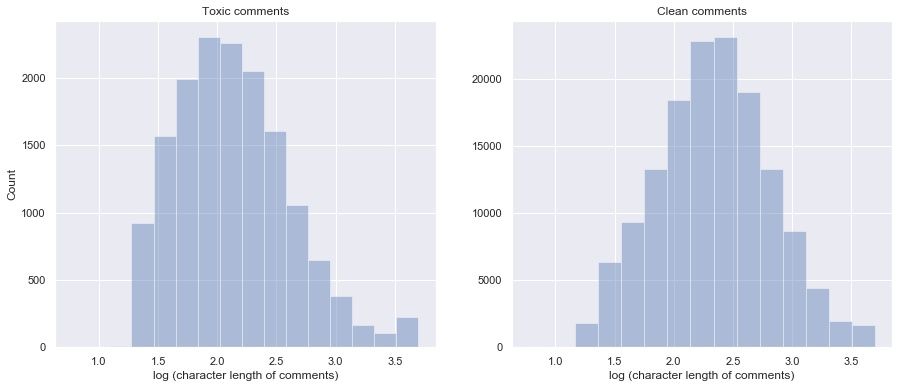

In [12]:
sns.set(palette='deep')
fig, ax = plt.subplots(1,2,sharex=True, figsize=(15,6))
_=sns.distplot(np.log10(train.loc[train.toxic==1,'len_comment']),kde=False, bins=15,ax=ax[0])
_=ax[0].set_xlabel('log (character length of comments)')
_=ax[0].set_ylabel('Count')
_=ax[0].set_title('Toxic comments')

_=sns.distplot(np.log10(train.loc[train.toxic==0,'len_comment']),kde=False, bins=15,ax=ax[1])
_=ax[1].set_xlabel('log (character length of comments)')
_=ax[1].set_title('Clean comments')
print('mean character length of toxic comments: {}'.format(train.loc[train.toxic==1,'len_comment'].mean()))
print('mean character length of clean comments: {}'.format(train.loc[train.toxic==0,'len_comment'].mean()))

#### The clean comments are longer than the toxic comments.

In [13]:
train_text = train['comment_text']
test_text = test['comment_text']

## Text preprocessing

This is a very crucial step in NLP. One has to represent the documents in the corpus as vectors containing numeric values. Why? Because the classification algorithm we will use to classify toxic comments does not understand text, it can only work with numbers. The following steps will be performed:
 - Converting each document to lowercase characters.
 - Removing punctuations.
 - Tokenizing: Split up a string in to its constituent tokens, in this case, words composed of English characters.
 - Removing English stopwords, like is, and, the, for, etc.
 - Lemmatization. This reduces words to their root form. For e.g. *running* will be reduced to *run*, so will be *ran*. Lemmatization is slightly different to a related concept, stemming. 
 

In [14]:
import string 
punctuation_set = set(string.punctuation)

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def preprocess_comment(comment_str):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    comment=re.sub(r"(\d{1,3}\.){1,3}\d{1,3}","",comment_str)  #remove ip's
    words = [word for word in tokenizer.tokenize(comment.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    clean_words = [word for word in words if word not in punctuation_set] #remove puntuations
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word,pos = get_wordnet_pos(word)) for word in clean_words if len(word)>2]) ## lemmatization
    return lemmatized_sentence         

In [16]:
# An example
print('Original text:\n {}'.format(train_text[1010]))
print('After cleaning:\n {}'.format(preprocess_comment(train_text[1010])))

Original text:
 "
 The only person claiming edit warring is you.  I urge you again to moderate your tone and abide by civility.   Padding Romm's entry with insubstantial fluff like what his brother does for a living and lengthy descriptions of projects he ""helped with"" has no place in an encyclopedia entry.   "
After cleaning:
 person claim edit war urge moderate tone abide civility pad romm entry insubstantial fluff like brother living lengthy description project help place encyclopedia entry


In [17]:
train_text = train_text.apply(lambda comment: preprocess_comment(comment))

In [18]:
test_text = test_text.apply(lambda comment: preprocess_comment(comment))

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [20]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
#    preprocessor= preprocess_comment,
    max_df = 0.7,
    ngram_range=(1, 2),
    max_features=40000)
word_vectorizer.fit(train_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=40000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
import time
start = time.time()
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)
end = time.time()
print((end-start)/60,'mins')

0.827665650844574 mins


In [22]:
print('Train matrix shape: {}'.format(train_word_features.shape))
print('Test matrix shape: {}'.format(test_word_features.shape))

Train matrix shape: (159571, 40000)
Test matrix shape: (153164, 40000)


In [23]:
feature_names = word_vectorizer.get_feature_names()

### Visualizing tf-idf features

In [24]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(X, features, row_id, top_n=10):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [25]:
rand_index = np.random.choice(range(len(train)), size=1)[0]
print(train.loc[rand_index, 'comment_text'])
top_feats_in_doc(train_word_features, feature_names, rand_index, top_n=5)

Hi Dawn, I dont know if you work for the PMO, or if youre just a political partisan, but defending Mike Duffy is beyond the pale. How do yhou sleep at night? Fuck off, you can revert all you fucking want, it will be The Dishonourable until such time as Mike Duffy (and Duffy ALONE) pays back the 90,0000$ owed


,feature,tfidf
0,duffy,0.513011
1,mike,0.289300
2,beyond pale,0.230642
3,sleep night,0.229515
4,fuck want,0.222870


In [26]:
def cross_val(clf,Xtrain=train_word_features, cv=3):
    scores = []
    class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    for class_name in class_names:
        train_target = train[class_name]
        cv_score = np.mean(cross_val_score(clf, Xtrain, train_target, cv=cv, scoring='roc_auc'))
        scores.append(cv_score)
        print('CV score for class {} is {}'.format(class_name, cv_score))
    print('Mean CV score is {}'.format(np.mean(scores)))

In [27]:
clf_NB = MultinomialNB(alpha=0.1)
clf_logreg = LogisticRegression(C=0.2, solver= 'sag')
print('--------Naive Bayes----------\n')
cross_val(clf_NB,cv=5)
print('--------Logistic Regression----------\n')
cross_val(clf_logreg,cv=5)

--------Naive Bayes----------

CV score for class toxic is 0.9513803241417328
CV score for class severe_toxic is 0.9763298761956133
CV score for class obscene is 0.9619342927468779
CV score for class threat is 0.9520995632133153
CV score for class insult is 0.9595532264624074
CV score for class identity_hate is 0.9534516424251848
Mean CV score is 0.9591248208641886
--------Logistic Regression----------

CV score for class toxic is 0.9652985026926416
CV score for class severe_toxic is 0.9848796333336638
CV score for class obscene is 0.9837595082656664
CV score for class threat is 0.9765741237618769
CV score for class insult is 0.974623842579472
CV score for class identity_hate is 0.9724578132338451
Mean CV score is 0.9762655706445277


In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
import xgboost as xgb

In [30]:
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=300, n_jobs=-1,random_state=42)
cross_val(xgb_model)

CV score for class toxic is 0.9523210169553802
CV score for class severe_toxic is 0.9776601744140581
CV score for class obscene is 0.9812156860755475
CV score for class threat is 0.9636599489620544
CV score for class insult is 0.9680945350130753
CV score for class identity_hate is 0.964488887725074
Mean CV score is 0.9679067081908649


- **XGBoost surprisingly does not perform well in this task! I agree that I haven't followed a rigorous method of grid search to find the optimum set of hyperparameters because of my computing limitations, but those who have tried that approach weren't successful either.**

In [31]:
submission = pd.DataFrame.from_dict({'id': test['id']})
classifier = clf_logreg
for class_name in class_names:
    classifier.fit(train_word_features, train[class_name])
    submission[class_name] = classifier.predict_proba(test_word_features)[:, 1]
submission.to_csv('submission.csv', index=False)

In [32]:
def plot_and_return_top_features(classifier, vectorizer, class_name, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(ce)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.title('{} comments'.format(class_name))
    plt.ylabel('Feature coefficient values')
    plt.show()
    return top_coefficients


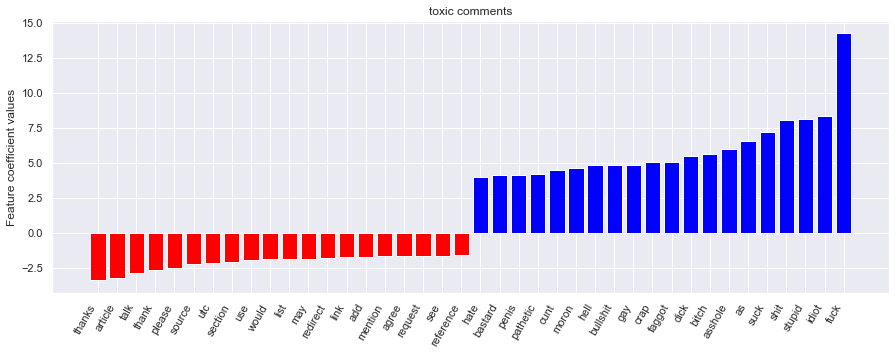

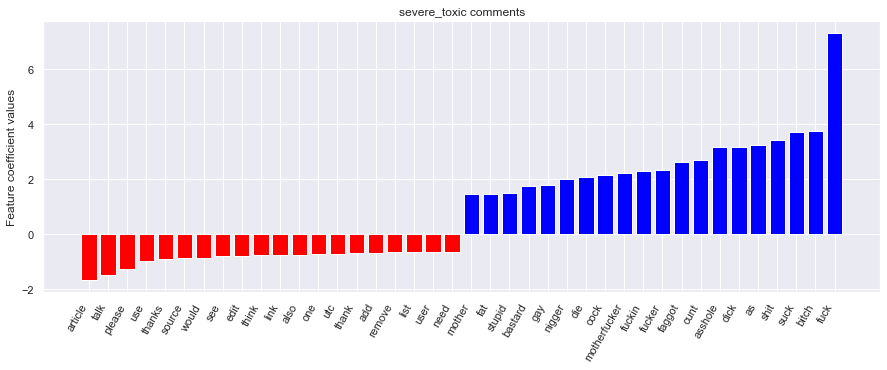

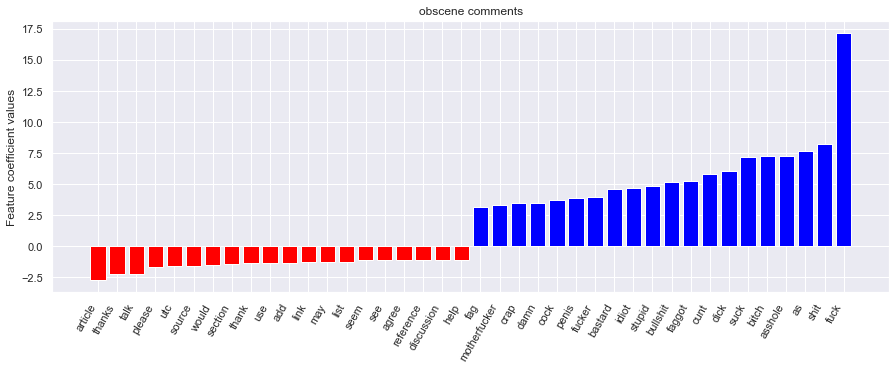

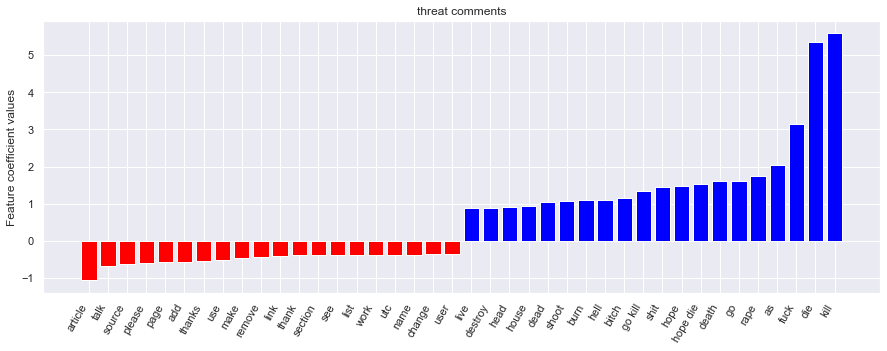

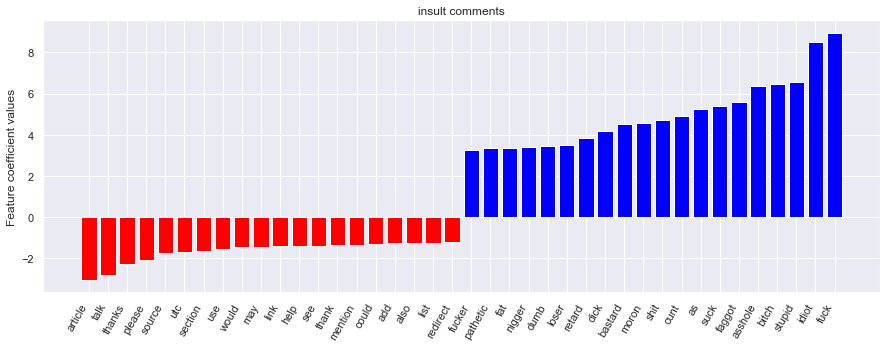

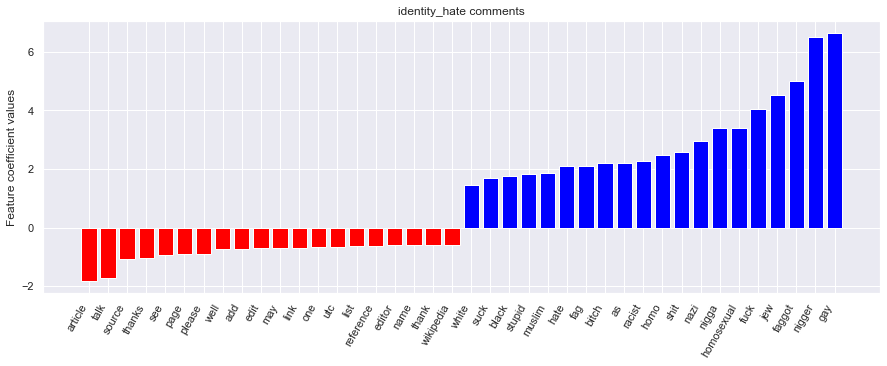

In [33]:

for class_name in class_names:
    logreg = LogisticRegression(C=0.2, solver= 'sag')
    logreg.fit(train_word_features, train[class_name])
    _=plot_and_return_top_features(logreg, word_vectorizer, class_name, 20)

## Topic modelling

We will use Latent Dirichlet Allocation, or LDA, for topic modelling. For more information on LDA, you can check out this [article](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d).

**What is topic modelling?**

One can think of topic modelling as an unsupervised clustering technique. Given a corpus of documents, in this case, a corpus of Wikipedia comments, the algorithm (here, LDA) tries to find the latent factors or topics based on the words. LDA will not see the labels. It will be interesting to see if LDA can actually segregate the comments into clean and toxic comments, and furthermore find the substructures in the levels of toxicity.

- We will first prepare the dictionary and the corpus for gensim's LDA module. It's fairly straightforward, you first create a dictionary of all the tokens (basically means that you map each token to a unique number) and then create a bag of words model with word counts. This will constitute the corpus.

In [34]:
tokenized_clean_train_text = [word_tokenize(doc) for doc in train_text]
gensim_dict = Dictionary(tokenized_clean_train_text)
gensim_dict.save('dictionary.dict')

/Users/debashis/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [35]:
print(train_text[4657])  #random comment
print('The id for the word \'mean\' is: {}'.format(gensim_dict.token2id['mean']))   # finding the id for a word from the gensim dictionary

mean mean forever ever block wikipedia huh well thats disappoint
The id for the word 'mean' is: 354


In [36]:
#Now convert each document into the bag-of-words (BoW) format = list of (token_id, token_count).
corpus = [gensim_dict.doc2bow(doc) for doc in tokenized_clean_train_text]
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)

- **In LDA, one has to provide the number of topics as an input. There is no science behind finding this number, although one might be guided by the problem statement in hand. In this particular case, since it is known that the data has 6 labels, one might expect LDA algorithm to find 6 different topics.**

In [37]:
num_topics=5
start = time.time()
lda = LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics,chunksize=2000, random_state=42)
#lda.save('lda_5_topics.ldamodel')
print((time.time() - start)/60, 'mins')

3.2083832462628683 mins


### Visualizing the topics

In [38]:
def show_topics(model,num_topics=5):
    topics = {}
    for i in range(num_topics):
        topics[i] = [tup[0] for tup in model.show_topic(i)]
    topics_lda_df = pd.DataFrame(data=topics)
    topics_lda_df.columns = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
    return topics_lda_df

show_topics(lda,num_topics=5)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,name,say,page,article,fuck
1,http,one,article,wikipedia,lol
2,one,would,talk,page,get
3,people,know,edit,use,fat
4,aid,hate,wikipedia,image,faggot
5,state,also,make,please,suck
6,say,think,user,add,huge
7,also,year,like,source,stupid
8,source,school,get,deletion,love
9,jew,fact,block,link,hey


- Okay, what you see is that there are clearly two groups. Topics 1 through 4 basically are composed of clean/non-toxic words, whereas topic 5 is clearly different from the rest. It contains all those words which you classify as obscene,toxic, vulgar, and insulting.
- In the bar plots below, we'll represent the topic words along with their probabilities/relevance within that topic.

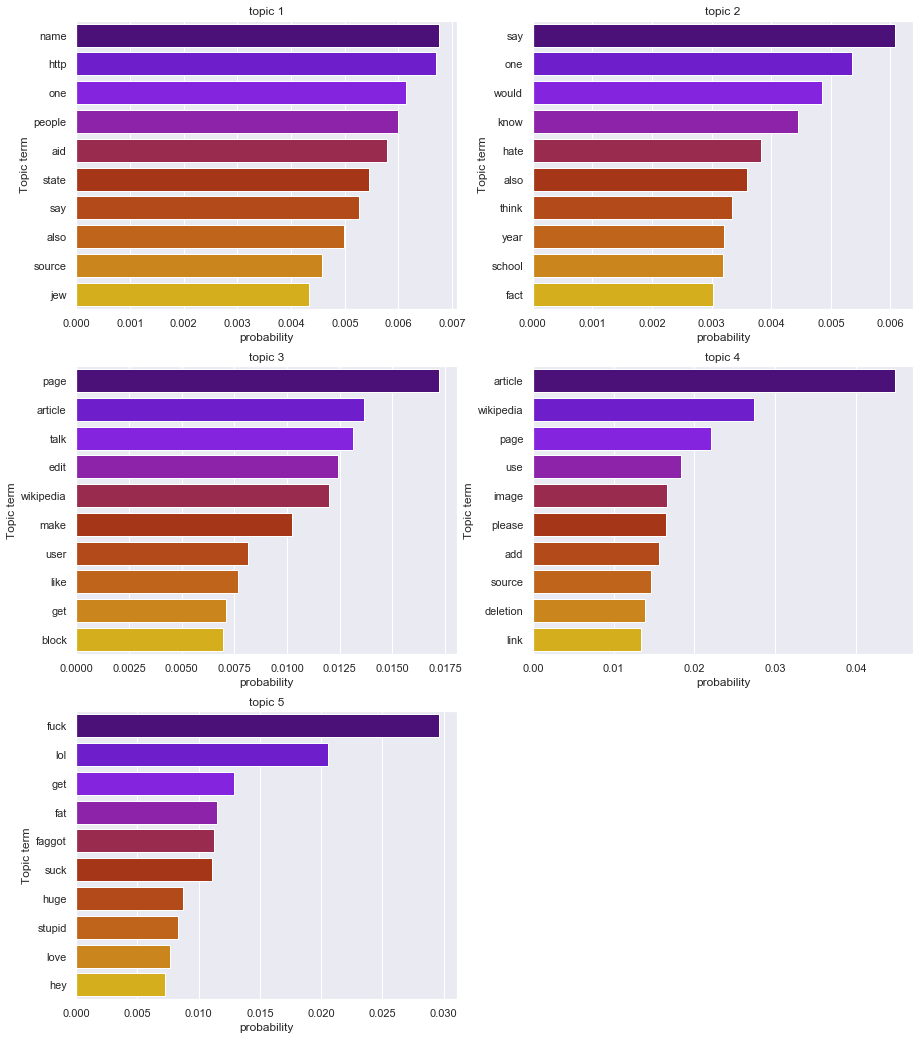

In [73]:
fig=plt.figure(figsize=(15,18))
for i in range(num_topics):
    df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')    
    plt.subplot(3,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, palette='gnuplot')
    plt.xlabel('probability')
    plt.ylabel('Topic term')

### LDA with tf-idf features

We can also try to perform LDA with tf-idf vectors of each document instead of just count vectors. Hopefully it will segregate the topics better? Let's find out!

In [39]:
from gensim import models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [85]:
num_topics=5
start = time.time()
lda_tfidf = LdaModel(corpus_tfidf, id2word=gensim_dict, num_topics=num_topics, chunksize=2000,random_state=42)
print((time.time() - start)/60, 'mins')

1.2948686639467875 mins


In [86]:
topics_tfidf = show_topics(lda_tfidf,num_topics=5)
topics_tfidf

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,jew,dude,article,image,fuck
1,http,redirect,page,deletion,test
2,redirect,annoy,talk,speedy,sandbox
3,www,korean,edit,tag,experiment
4,greek,twat,wikipedia,copyright,suck
5,country,retard,please,delete,shit
6,com,till,block,criterion,gay
7,british,damn,thanks,file,bitch
8,kill,accident,make,jpg,as
9,muslim,redirects,source,fair,faggot


#### Looks promising! 
1. In this case too, topic 5 is clearly the most well-defined topic for obscenity/toxicity. The interesting bit is that Topic 1 now contains elements of identity-hate, which was absent in the LDA model with count features only.

2. Let's label the topics in the dataframe!

In [87]:
topics_tfidf.columns = ['identity_hate', 'toxic', 'clean', 'clean?', 'obscene']
topics_tfidf

,identity_hate,toxic,clean,clean?,obscene
0,jew,dude,article,image,fuck
1,http,redirect,page,deletion,test
2,redirect,annoy,talk,speedy,sandbox
3,www,korean,edit,tag,experiment
4,greek,twat,wikipedia,copyright,suck
5,country,retard,please,delete,shit
6,com,till,block,criterion,gay
7,british,damn,thanks,file,bitch
8,kill,accident,make,jpg,as
9,muslim,redirects,source,fair,faggot


|I think it did a fair job given the fact that there was quite some overlap between the levels of toxicity.

### Visualizing the topics with `PyLDAviz`

In [43]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

In [44]:
#lda = gensim.models.LdaModel.load('lda_10_topics.ldamodel')
#corpus = gensim.corpora.MmCorpus('corpus.mm')
#gensim_dict = gensim.corpora.Dictionary.load('dictionary.dict')

In [45]:
start = time.time()
lda_display = pyLDAvis.gensim.prepare(lda, corpus, gensim_dict)
end = time.time()
print((end-start)/60,'mins')

/Users/debashis/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


175.76444736321767 mins


In [46]:
pyLDAvis.display(lda_display)

**What we discussed earlier is even more clear in the visualization above. Topic number 5 has got a place of its own, far from all the other blobs. If you look at the relevant terms from the other topics, there is not much to discriminate amongst them. **


## Find the topic of a new document from the test set

Recall that LDA is a generative model Given a document which the model has not seen before, it will assign a topic to it based ob the probability distribution of the words. Let's try it out with a document from the test set.

In [52]:
newdoc = test_text[np.random.choice(range(len(test_text)),size=1)[0]]
print(newdoc)
new_doc_bow = gensim_dict.doc2bow(word_tokenize(preprocess_comment(newdoc)))

file chaudhryrehmat jpg list deletion file uploaded alter file chaudhryrehmat jpg list wikipedia file deletion please see discussion see list may search title image find entry feel free add opinion matter nomination thank


In [48]:
topic_proba_sorted = sorted(lda.get_document_topics(new_doc_bow),key = lambda row: row[1],reverse=True)
print(topic_proba_sorted)
ind_max_proba_topic = topic_proba_sorted[0][0]

[(2, 0.49738345), (3, 0.3458163), (0, 0.05380696), (4, 0.052964125), (1, 0.050029185)]


In [53]:
print('Topic words for the given document:\n {}'.format(', '.join([row[0] for row in lda.show_topic(ind_max_proba_topic)])))

Topic words for the given document:
 page, article, talk, edit, wikipedia, make, user, like, get, block


- I would say it worked pretty well. It correctly identified the topic of the comment.